# Education Infrastructure

In this notebook, we will perform a **damage and risk assessment** for education infrastructure. The assessment is based on combining hazard data (e.g., flood depths) with vulnerability curves to estimate the potential damage to infrastructure.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., secondary schools) and hazard data (e.g., flood depths) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the damage assessment:**  
   We will apply vulnerability curves to estimate the potential damage based on the intensity of the hazard.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated damage using graphs and maps to illustrate the impact on education infrastructure.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will need to install the packages below **(remove the hashtag in front of them)**. The installation is split into two steps:

**Step 1:** Install `damagescanner` first. Because this upgrades NumPy to a newer version than what Colab has pre-installed, Google Colab will prompt you to restart the runtime after installation — **accept the restart**. This is necessary to ensure the newly installed NumPy version is actually loaded into memory.

**Step 2:** After the restart, run the second cell to install `contextily`. This package is installed separately to avoid the installation to fail due to the requested runtime restart.

In [1]:
#!pip install damagescanner

In [ ]:
#!pip install contextily

In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [2]:
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely

import matplotlib.pyplot as plt
import contextily as cx

import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
from damagescanner.config import DICT_CIS_VULNERABILITY_FLOOD

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

### Specify the country of interest

Before we continue, we should specify the country for which we want to assess the damage. We use the ISO3 code for the country to download the OpenStreetMap data.

In [3]:
country_full_name = 'Jamaica'
country_iso3 = 'JAM'

## 2. Loading the Data
In this step, we will load four key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of education infrastructure (e.g., schools or universities). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

3. **Vulnerability curves:**  
   Vulnerability curves define how the infrastructure's damage increases with the intensity of the hazard. For example, flood depth-damage curves specify how much damage occurs for different flood depths.

4. **Maximum damage values:**  
   This dataset contains the maximum possible damage (in monetary terms) that can be incurred by individual infrastructure assets. This is crucial for calculating total damage based on the vulnerability curves.

### Infrastructure Data

We will perform this example analysis for Jamaica. To start the analysis, we first download the OpenStreetMap data from GeoFabrik. 

In [4]:
infrastructure_path = download.get_country_geofabrik(country_iso3)

Now we load the data and read only the healthcare data.

In [5]:
%%time
features = read_osm_data(infrastructure_path,asset_type='education')

CPU times: total: 26.5 s
Wall time: 51.9 s


In [6]:
sub_types = features.object_type.unique()

In [7]:
sub_types

<ArrowStringArray>
['school', 'kindergarten', 'college', 'university', 'library']
Length: 5, dtype: str

### Hazard Data
For this example, we make use of the flood data provided by [CDRI](https://giri.unepgrid.ch/map?list=explore).

We use a 1/100 flood map to showcase the approach.

In [8]:
hazard_map = xr.open_dataset("https://hazards-data.unepgrid.ch/global_pc_h100glob.tif", engine="rasterio")

In [9]:
hazard_map

<xarray.Dataset> Size: 747GB
Dimensions:      (band: 1, x: 432000, y: 216000)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 3MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 2MB 90.0 90.0 90.0 90.0 ... -90.0 -90.0 -90.0 -90.0
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float64 746GB ...

### Maximum damages
One of the most difficult parts of the assessment is to define the maximum reconstruction cost of particular assets. Here we provide a baseline set of values, but these should be updated through national consultations.

Locations of education facilities are (somewhat randomly) geotagged as either points or polygons. This matters quite a lot for the maximum damages. For polygons, we would use damage per square meter, whereas for points, we would estimate the damage to the entire asset at once. Here we take the approach of converting the points to polygons, and there define our maximum damages in dollar per square meter. 

In [10]:
maxdam_dict = {'community_centre' : 1000, 
               'school' : 1000, 
               'kindergarten' : 1000, 
               'university' : 1000, 
               'college' : 1000,
               'library' : 1000
              }

To be used in our damage assessment, we convert this to a Pandas DataFrame

In [11]:
maxdam = pd.DataFrame.from_dict(maxdam_dict,orient='index').reset_index()
maxdam.columns = ['object_type','damage']

And check if any of the objects are missing from the dataframe.

In [12]:
missing = set(sub_types) - set(maxdam.object_type)

if len(missing) > 0:
    print(f"Missing object types in maxdam: \033[1m{', '.join(missing)}\033[0m. Please add them before you continue.")

### Vulnerability data
Similarly to the maximum damages, specifying the vulnerability curves is complex. We generally have limited information about the quality of the assets, its level of deteriation and other asset-level characteristics.

In [13]:
vulnerability_path = "https://zenodo.org/records/10203846/files/Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx?download=1"
vul_df = pd.read_excel(vulnerability_path,sheet_name='F_Vuln_Depth').ffill()

And let's have a look at all the available options

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
  display(vul_df.iloc[:2,:].T)

,0,1
ID number,Infrastructure description,Additional characteristics
F1.1,plant,"Small power plants, capacity <100 MW"
F1.2,plant,"Medium power plants, capacity 100-500 MW"
F1.3,plant,"Large power plants, >500 MW"
F1.4,plant,thermal plant
F1.5,plant,wind turbine
F1.6,plant,wind turbine
F1.7,plant,wind turbine
F2.1,substation,Low Voltage Substation
F2.2,substation,Medium Voltage Substation


And select a curve to use for each different subtype we are analysing.

In [15]:
sub_types

<ArrowStringArray>
['school', 'kindergarten', 'college', 'university', 'library']
Length: 5, dtype: str

In [16]:
selected_curves = dict(zip(sub_types,['F21.7','F21.7','F21.7','F21.7','F21.7','F21.7']))

The next step is to extract the curves from the database, and prepare them for proper usage into our analysis.

We start by selecting the curve IDs from the larger pandas DataFrame **vul_df**:

In [17]:
damage_curves = vul_df[['ID number']+list(selected_curves.values())]
damage_curves = damage_curves.iloc[4:125,:]

Then for convenience, we rename the index name to the hazard intensity we are considering. 

In [18]:
damage_curves.set_index('ID number',inplace=True)
damage_curves.index = damage_curves.index.rename('Depth')  

And make sure that our damage values are in floating numbers. 

In [19]:
damage_curves = damage_curves.astype(np.float32)

And ensure that the columns of the curves link back to the different asset types we are considering:

In [20]:
damage_curves.columns = sub_types

There could be some **NaN** values at the tail of some of the curves. To make sure the code works, we fill up the **NaN** values with the last value of each of the curves. 

In [21]:
damage_curves = damage_curves.ffill()

Finally, make sure we set the index of the damage curves (the inundation depth) in the same metric as the hazard data (e.g. meters or centimeters).

In [22]:
damage_curves.index = damage_curves.index*100

But in some cases, we do not exactly know which curves we may want to use. As such, we can also run the analysis with all curves. To do so, we select all education-related curves from Nirandjan et al. (2024)'s database.

In [23]:
unique_curves = set([x for xs in DICT_CIS_VULNERABILITY_FLOOD['education'].values() for x in xs])

And create a dictionary that contains a pandas DataFrame for all object types, for each vulnerability curve. 

In [24]:
multi_curves = {}
for unique_curve in unique_curves:

    curve_creation = damage_curves.copy()
    
    get_curve_values = vul_df[unique_curve].iloc[4:125].values.astype(np.float32)
    
    for curve in curve_creation:
        
        curve_creation.loc[:, curve] = get_curve_values

    multi_curves[unique_curve] = curve_creation.astype(np.float32)

### Ancilliary data for processing

In [25]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

In [26]:
admin1 = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_1_states_provinces.shp")

## 3. Preparing the Data

Clip the hazard data to the country of interest.

In [27]:
country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry

In [28]:
hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )

### Convert point data to polygons. 

For some data, there are both points and polygons available. It makes life easier to estimate the damage using polygons. Therefore, we convert those points to Polygons below. 

Let's first get an overview of the different geometry types for all the assets we are considering in this analysis:

In [29]:
features['geom_type'] = features.geom_type

In [30]:
features.groupby(['object_type','geom_type']).count()['geometry']

object_type   geom_type   
college       MultiPolygon     11
              Point             7
kindergarten  MultiPolygon      4
              Point            12
library       MultiPolygon     14
              Point             4
school        MultiPolygon    288
              Point           116
university    MultiPolygon     16
              Point             2
Name: geometry, dtype: int64

The results above indicate that several asset types that are expected to be *Polygons* are stored as *Points* as well. It would be preferably to convert them all to polygons. For the *Points*, we will have to estimate a the average size, so we can use that to create a `buffer` around the assets.

To do so, let's grab the polygon data and estimate their size. We grab the median so we are not too much influenced by extreme outliers. If preferred, please change `.median()` to `.mean()` (or any other metric). 

In [31]:
polygon_features = features.loc[features.geometry.geom_type.isin(['Polygon','MultiPolygon'])].to_crs(3857)
polygon_features['square_m2'] = polygon_features.area

square_m2_object_type = polygon_features[['object_type','square_m2']].groupby('object_type').median()
square_m2_object_type

,square_m2
object_type,
college,60685.678091
kindergarten,849.080034
library,521.562639
school,11155.888564
university,616.038500


Now we create a list in which we define the assets we want to "polygonize": 

In [32]:
points_to_polygonize = ['college','kindergarten','library','school','university']

And take them from our data again:

In [33]:
all_assets_to_polygonize = features.loc[(features.object_type.isin(points_to_polygonize)) & (features.geometry.geom_type == 'Point')]

When performing a buffer, it is always best to do this in meters. As such, we will briefly convert the point data into a **crs** system in meters.

In [34]:
all_assets_to_polygonize = all_assets_to_polygonize.to_crs(3857)

In [35]:
def polygonize_point_per_asset(asset):

    # we first need to set a buffer length. This is half of width/length of an asset.
    buffer_length = np.sqrt(square_m2_object_type.loc[asset.object_type].values[0])/2

    # then we can buffer the asset
    return asset.geometry.buffer(buffer_length,cap_style='square')

collect_new_point_geometries = all_assets_to_polygonize.apply(lambda asset:  polygonize_point_per_asset(asset),axis=1).set_crs(3857).to_crs(4326).values

In [36]:
features.loc[(features.object_type.isin(points_to_polygonize)) & (features.geometry.geom_type == 'Point'),'geometry'] = collect_new_point_geometries

And check if any "undesired" *Points* are still left:

In [37]:
features.loc[(features.object_type.isin(points_to_polygonize)) & (features.geometry.geom_type == 'Point')]

,osm_id,geometry,object_type,building,name,geom_type


And remove the 'geom_type' column again, as we do not need it again.

In [38]:
features = features.drop(['geom_type'],axis=1)

## 5. Performing the Damage Assessment
We will use the DamageScanner approach. This is a fully optimised damage calculation method, that can capture a wide range of inputs to perform a damage assessment. We will first perform this using only a single damage curve.

In [39]:
%%time
damage_results = DamageScanner(hazard_country, features, damage_curves, maxdam).calculate()

Calculating damage: 100%|██████████████████████████████████████████████████████████| 474/474 [00:00<00:00, 5915.50it/s]

CPU times: total: 594 ms
Wall time: 1.56 s


And run this also with the range of vulnerability curves.

In [40]:
%%time
all_results = DamageScanner(hazard_country, features, damage_curves, maxdam).calculate(multi_curves=multi_curves)

Calculating damage: 100%|██████████████████████████████████████████████████████████| 474/474 [00:00<00:00, 4272.76it/s]


CPU times: total: 688 ms
Wall time: 1.37 s


## 5. Save the Results
For further analysis, we can save the results in their full detail, or save summary estimates per subnational unit 

In [41]:
hazard = 'river_flood'
return_period = '1_100'
damage_results.to_file(f'Education_Damage_{country_full_name}_{hazard}_{return_period}.gpkg')

In [42]:
admin1_country = admin1.loc[admin1.sov_a3 == country_iso3]

In [43]:
damage_results = damage_results.sjoin(admin1_country[['adm1_code','name','geometry']])

## 6. Visualizing the Results
The results of the damage assessment can be visualized using charts and maps. This will provide a clear representation of which infrastructure is most affected by the hazard and the expected damage levels.

And create a distribution of the damages.

<Axes: xlabel='damage', ylabel='Count'>

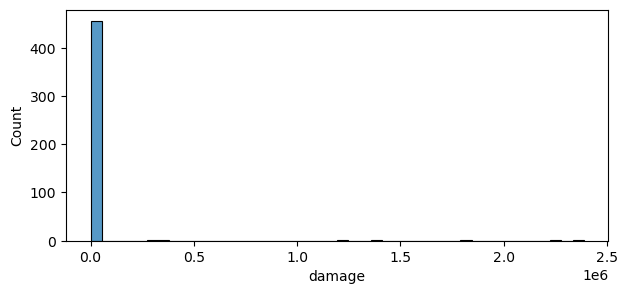

In [44]:
fig, ax = plt.subplots(1,1,figsize=(7, 3))

sns.histplot(data=damage_results,x='damage',ax=ax)

Plot location of most damaged healthcare facilities

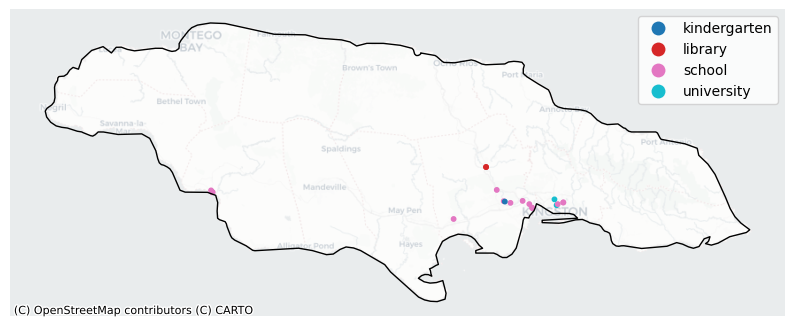

In [45]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))

subset = damage_results.to_crs(3857).sort_values('damage',ascending=False).head(20)
subset.geometry = subset.centroid
subset.plot(ax=ax,column='object_type',markersize=10,legend=True)
world_plot.loc[world.SOV_A3 == country_iso3].plot(ax=ax,facecolor="none",edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

## 7. Performing the Risk Assessment
To do so, we need to select the return periods we want to include, and create a dictioniary as input. We will create this below.

In [46]:
return_periods = [2,5,10,50,100,200,500,1000] 

hazard_dict = {}
for return_period in return_periods:
    hazard_map = xr.open_dataset(f"https://hazards-data.unepgrid.ch/global_pc_h{return_period}glob.tif", engine="rasterio")

    hazard_dict[return_period] = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )
    

And below we will run a multi-curve risk assessment.

In [47]:
risk_results = DamageScanner(hazard_country, features, damage_curves, maxdam).risk(hazard_dict,multi_curves=multi_curves)

Risk Calculation: 100%|██████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.58s/it]


In [48]:
grouped_risks = risk_results[['object_type']+list(multi_curves.keys())].groupby('object_type').sum()

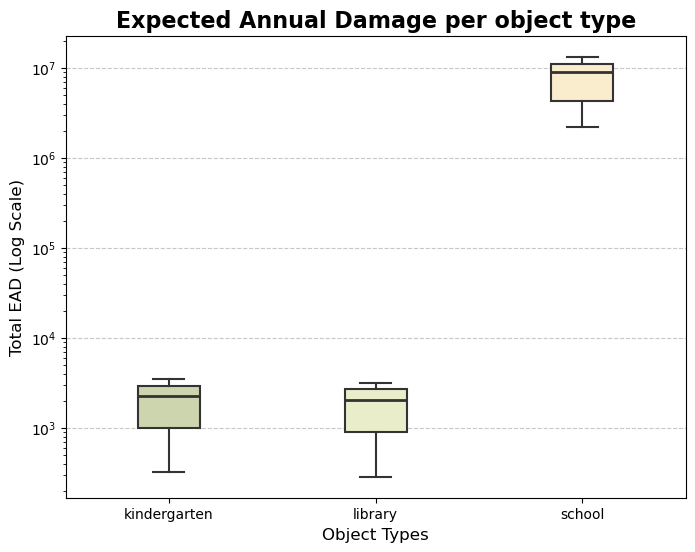

In [49]:
# Re-attempting with explicit assignment of the boxplot object
plt.figure(figsize=(8, 6))

# Creating the boxplot explicitly to access its elements
boxplot = grouped_risks.T.boxplot(column=['kindergarten', 'library', 'school'], grid=False, patch_artist=True, return_type='dict')

# Customizing box colors and ensuring all lines have the same color
colors = ['#ccd5ae', '#e9edc9', '#faedcd']
line_color = '#333333'  # Uniform line color for all components

# Customizing boxes
for box, color in zip(boxplot['boxes'], colors):  # Accessing box artists
    box.set_facecolor(color)
    box.set_edgecolor(line_color)
    box.set_linewidth(1.5)

# Customizing whiskers, caps, medians, and fliers
for whisker in boxplot['whiskers']:
    whisker.set_color(line_color)
    whisker.set_linewidth(1.5)

for cap in boxplot['caps']:
    cap.set_color(line_color)
    cap.set_linewidth(1.5)

for median in boxplot['medians']:
    median.set_color(line_color)
    median.set_linewidth(2)

for flier in boxplot['fliers']:
    flier.set_markerfacecolor(line_color)
    flier.set_markeredgecolor(line_color)

# Adding titles and labels
plt.title('Expected Annual Damage per object type', fontsize=16, fontweight='bold')
plt.ylabel('Total EAD (Log Scale)', fontsize=12)
plt.xlabel('Object Types', fontsize=12)
plt.yscale('log')  # Using log scale for better visualization of large range
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)

# Adding gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the boxplot
plt.show()
